## Import Libararies

In [14]:
import numpy as np
from sklearn.metrics import pairwise_distances as pdist
from astropy.table import Table
from matplotlib import pyplot as plt
from astroptical.photometry import magnitude 
import pyregion as pyreg
from os import path
from astroptical.photometry import magerr
import astropy.units as u
#import seaborn as sns
#sns.set()

# 3rd Party Imports
import pysynphot as psp  # Can't seem to ignore AstropyDeprecationWarning
import matplotlib as mpl
from matplotlib.collections import LineCollection
from astroptical import reddening as ext
# AstrOptical
from astroptical import ssp

pathDir='/Users/sunil/Documents/TestESO_137_002/ESO-137-002/09_color_mag_regions'
colorDir='/Users/sunil/Documents/TestESO_137_002/ESO-137-002/10_surface_brightness_profile/output/'
# Starburst99 File
SSP_DIR       = '/Users/sunil/Documents/TestESO_137_002/ESO-137-002/11_SB99/Sims'
SSP_FILE_NAME = path.join(SSP_DIR, 'TailSim0_Genv00_014/TailSim0_Genv00_014.spectrum1')
#Cloudy File for eso
cloudy=Table.read('/Users/sunil/Documents/TestESO_137_002/ESO-137-002/11_SB99/Sims/Genv00-Track-Cloudy.csv');

%matplotlib notebook

# MPL Setup
GOLD = (1 + np.sqrt(5))/2
mpl.rc('font', **{'size': 14})
mpl.rc('figure', **{'figsize': (10, 10/GOLD)})

## Correcting correlate noise when using AstroDrizzle

In [2]:
Fc_F275W=0.5625; Fc_F475W=0.48; Fc_F814W=0.48;

In [3]:
f42 = Table.read('ESO_F475WxF275W.cat', format ='ascii.sextractor');
f44 = Table.read('ESO_F475WxF475W.cat', format ='ascii.sextractor'); 
f48 = Table.read('ESO_F475WxF814W.cat', format ='ascii.sextractor');

f42['MAG_APER'] = magnitude(f42['FLUX_APER'], 24.1713, 1.096)[1]*u.mag/u.ct;
f44['MAG_APER'] = magnitude(f44['FLUX_APER'], 26.059,  0.653)[1]*u.mag/u.ct;
f48['MAG_APER'] = magnitude(f48['FLUX_APER'], 25.948,  0.305)[1]*u.mag/u.ct;

f42['MAGERR_APER']=magerr(f42['FLUX_APER'],f42['FLUXERR_APER'])/Fc_F275W*u.mag/u.ct;
f44['MAGERR_APER']=magerr(f44['FLUX_APER'],f44['FLUXERR_APER'])/Fc_F475W*u.mag/u.ct;
f48['MAGERR_APER']=magerr(f48['FLUX_APER'],f48['FLUXERR_APER'])/Fc_F814W*u.mag/u.ct;

/Users/sunil/Downloads/AstrOptical/astroptical/photometry.py:42: RuntimeWarning: divide by zero encountered in log10
  mag    = -2.5*np.log10(flux) + zeroPoint - galExt - apCor - kcor
/Users/sunil/Downloads/AstrOptical/astroptical/photometry.py:67: RuntimeWarning: invalid value encountered in true_divide
  return LOG_ERR_COEF * fluxErr / flux


### `1. choose only overlapped filter region (remove borders)`

In [4]:
no_edge=pyreg.open(path.join(pathDir,'all_region.reg'));
filt_no_edge=no_edge.get_filter();

notedge_F475W=filt_no_edge.inside_x_y(f44['X_IMAGE'], f44['Y_IMAGE']);


### `2. Mag limit & Color limit to mask bright srcs, guide star catalog, saturated srcs & artifacts`

In [5]:
mask_F475W=(f44[notedge_F475W]['MAG_APER'] > 20.30) & (f44[notedge_F475W]['MAG_APER'] < 27.20) & \
(f48[notedge_F475W]['MAG_APER'] > 20.06) & (f48[notedge_F475W]['MAG_APER'] < 26.38) & \
(f42[notedge_F475W]['MAG_APER'] > 21.30) & (f42[notedge_F475W]['MAG_APER'] < 33.80) &\
(f42[notedge_F475W]['MAG_APER']-f44[notedge_F475W]['MAG_APER'] < 5.0) &\
(f44[notedge_F475W]['MAG_APER']-f48[notedge_F475W]['MAG_APER'] < 3.5)

### `3. Masking spurious objects`

In [16]:
regList_spurrious=pyreg.open(path.join(pathDir,'guidestar_spurr.reg'));
filt_spurrious=regList_spurrious.get_filter();
inSpurr_f475W=filt_spurrious.inside_x_y(f44[notedge_F475W][mask_F475W]['X_IMAGE'], f44[notedge_F475W][mask_F475W]['Y_IMAGE']);

## `4. Removing > 1 sigma error`

In [17]:
err_f475W=(f42[notedge_F475W][mask_F475W][inSpurr_f475W]['MAGERR_APER'] > 0) & (f42[notedge_F475W][mask_F475W][inSpurr_f475W]['MAGERR_APER'] < 1) & (f44[notedge_F475W][mask_F475W][inSpurr_f475W]['MAGERR_APER'] > 0) & (f44[notedge_F475W][mask_F475W][inSpurr_f475W]['MAGERR_APER'] < 1) & (f48[notedge_F475W][mask_F475W][inSpurr_f475W]['MAGERR_APER'] > 0) & (f48[notedge_F475W][mask_F475W][inSpurr_f475W]['MAGERR_APER'] < 1);

### 5.  `selecting tail & control regions`

In [18]:
regList_tail=pyreg.open(path.join(pathDir,'tail.reg'));
regList_control=pyreg.open(path.join(pathDir,'control.reg'));
            
filt_tail=regList_tail.get_filter();
filt_control=regList_control.get_filter();

In [19]:
inTail_F475W=filt_tail.inside_x_y(f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W]['X_IMAGE'], f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W]['Y_IMAGE']);
inControl_F475W=filt_control.inside_x_y(f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W]['X_IMAGE'], f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W]['Y_IMAGE']);

## check-1

In [12]:
with open(path.join(pathDir,'delete_tail.reg'),'w') as fid:
    for x,y in zip(f42[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][inTail_F475W]['X_IMAGE'],f42[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][inTail_F475W]['Y_IMAGE']):
            fid.write('{}{}{:.4f}{} {:.4f}{}{}{}\n'.format('circle','(',x,',',y,',50',')',' # color=white'))

In [11]:
#len(f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][inTail_F475W])

### check extrem srcs in color limit

In [12]:
#check for extreme sources
#color_F475W_control=(mc42-mc44 < 5)  & (mc44-mc48 < -1)
# flux, coordinates and mag from SExtractor for F475W
#f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][inControl_F475W][color_F475W_control]['NUMBER', 'X_IMAGE','Y_IMAGE', 'FLUX_APER','MAG_APER']
#print(mc44[color_F475W_control] - mc48[color_F475W_control])

## 6. `Calculate magnitude`

In [20]:
#tail_srcs
mt42 = f42[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][inTail_F475W]['MAG_APER'];
mt44 = f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][inTail_F475W]['MAG_APER'];
mt48 = f48[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][inTail_F475W]['MAG_APER'];
#control_srcs
mc42 = f42[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][inControl_F475W]['MAG_APER'];
mc44 = f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][inControl_F475W]['MAG_APER'];
mc48 = f48[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][inControl_F475W]['MAG_APER'];

### `Median Errors in Tail/Control for upper_limits` 

In [11]:
tail_x=np.median(np.sqrt(f42[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][inTail_F475W]['MAGERR_APER']**2 \
             + f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][inTail_F475W]['MAGERR_APER']**2));
tail_y=np.median(np.sqrt(f48[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][inTail_F475W]['MAGERR_APER']**2 \
                        + f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][inTail_F475W]['MAGERR_APER']**2));


con_x=np.median(np.sqrt(f42[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][inControl_F475W]['MAGERR_APER']**2 \
             + f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][inControl_F475W]['MAGERR_APER']**2));

con_y=np.median(np.sqrt(f48[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][inControl_F475W]['MAGERR_APER']**2 \
                        + f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][inControl_F475W]['MAGERR_APER']**2));

print('tail_x:','{:.2f}'.format(tail_x), 'tail_y:','{:.2f}'.format(tail_y))
print('control_x:','{:.2f}'.format(con_x), 'control_y:','{:.2f}'.format(con_y))

tail_x: 0.57 tail_y: 0.02
control_x: 0.66 control_y: 0.06


# all-band detection/upper-limit

In [21]:
dual_srcs=pyreg.open(path.join(pathDir,'dual_srcs.reg'));
filt_dual=dual_srcs.get_filter();
dual_F475W=filt_dual.inside_x_y(f42[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W]['X_IMAGE'], f42[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W]['Y_IMAGE']);

In [22]:
#source present in all bands lower limit
dinTail_F475W=filt_tail.inside_x_y(f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W]['X_IMAGE'], f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W]['Y_IMAGE']);
dinControl_F475W=filt_control.inside_x_y(f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W]['X_IMAGE'], f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W]['Y_IMAGE']);
#soource only in F475W/F814W upper limit
einTail_F475W=filt_tail.inside_x_y(f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][~dual_F475W]['X_IMAGE'], f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][~dual_F475W]['Y_IMAGE']);
einControl_F475W=filt_control.inside_x_y(f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][~dual_F475W]['X_IMAGE'], f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][~dual_F475W]['Y_IMAGE']);

In [23]:
#tail_lower limit
mdt42 = f42[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W][dinTail_F475W]['MAG_APER'];
mdt44 = f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W][dinTail_F475W]['MAG_APER'];
mdt48 = f48[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W][dinTail_F475W]['MAG_APER'];
#control_lower limit
mdc42 = f42[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W][dinControl_F475W]['MAG_APER'];
mdc44 = f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W][dinControl_F475W]['MAG_APER'];
mdc48 = f48[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W][dinControl_F475W]['MAG_APER'];
#tail_upper_lim
met42 = f42[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][~dual_F475W][einTail_F475W]['MAG_APER'];
met44 = f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][~dual_F475W][einTail_F475W]['MAG_APER'];
met48 = f48[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][~dual_F475W][einTail_F475W]['MAG_APER'];
#control_upper_lim
mec42 = f42[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][~dual_F475W][einControl_F475W]['MAG_APER'];
mec44 = f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][~dual_F475W][einControl_F475W]['MAG_APER'];
mec48 = f48[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][~dual_F475W][einControl_F475W]['MAG_APER'];

### `calculate color excess in the F275W/F475W wrt to tail & control and compute total mag`

#### before running change the color limit to F275W - F475W < 2 and F475W -F814W < 1 

In [24]:
with open(path.join(pathDir,'color_excess_in_tail_control.reg'),'w') as fid:
    for x,y in zip(f42[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W][dinControl_F475W]['X_IMAGE'],f42[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W][dinControl_F475W]['Y_IMAGE']):
            fid.write('{}{}{:.4f}{} {:.4f}{}{}{}\n'.format('circle','(',x,',',y,',20',')',' # color=green'))

#### Tail region

In [228]:
# F275W also removed one of the brightest source which is a star
flux_sum_275=np.sum(f42[notedge_F475W][mask_F475W][inSpurr_f475W]\
                    [err_f475W][dual_F475W][dinTail_F475W]['FLUX_APER']) - 4.846811
# F475W
flux_sum_475=np.sum(f44[notedge_F475W][mask_F475W][inSpurr_f475W]\
                    [err_f475W][dual_F475W][dinTail_F475W]['FLUX_APER'])- 44.48848
mag_sum_275 =magnitude(flux_sum_275, 24.1713, 1.096)[1];
mag_sum_475 =magnitude(flux_sum_475, 26.059,  0.653)[1];

print('Total flux of 275W filter: ', '{:.2f}'.format(flux_sum_275))
print('Total mag of 275W filter:', '{:.2f}'.format(mag_sum_275))

print('Total flux of 475W filter: ', '{:.2f}'.format(flux_sum_475))
print('Total mag of 475W filter:', '{:.2f}'.format(mag_sum_475))

Total flux of 275W filter:  1.49
Total mag of 275W filter: 22.64
Total flux of 475W filter:  50.14
Total mag of 475W filter: 21.16


#### Control region

In [223]:
# F275W
flux_sum_275=np.sum(f42[notedge_F475W][mask_F475W][inSpurr_f475W]\
                    [err_f475W][dual_F475W][dinControl_F475W]['FLUX_APER'])

# F475W
flux_sum_475=np.sum(f44[notedge_F475W][mask_F475W][inSpurr_f475W]\
                    [err_f475W][dual_F475W][dinControl_F475W]['FLUX_APER'])\

mag_sum_275 =magnitude(flux_sum_275, 24.1713, 1.096)[1];
mag_sum_475 =magnitude(flux_sum_475, 26.059,  0.653)[1];

print('Total flux of 275W filter: ', '{:.2f}'.format(flux_sum_275))
print('Total mag of 275W filter:', '{:.2f}'.format(mag_sum_275))

print('Total flux of 475W filter: ', '{:.2f}'.format(flux_sum_475))
print('Total mag of 475W filter:', '{:.2f}'.format(mag_sum_475))

Total flux of 275W filter:  11.57
Total mag of 275W filter: 20.42
Total flux of 475W filter:  235.13
Total mag of 475W filter: 19.48


tail
0.74668325arcmin2

control
4.9657363arcmin2 

In [231]:
F275W_excess= 1.49 -11.57/4.97*0.747;
print('F275W excess','{:.2f}'.format(F275W_excess))

F475W_excess= 50.14 -235.13/4.97*0.747;
print('F475W excess','{:.2f}'.format(F475W_excess))

F275W excess -0.25
F475W excess 14.80


### check sourc in the CCD map

<IPython.core.display.Javascript object>


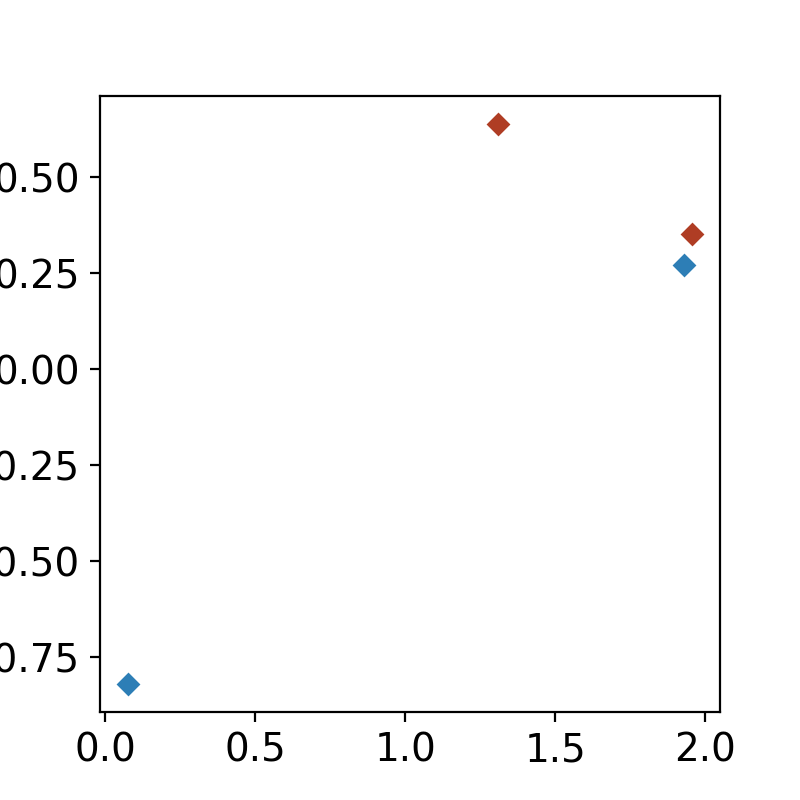

In [218]:

fig, ax= plt.subplots(figsize=(4, 4))

ax.scatter((mdt42-mdt44)[1:3],(mdt44-mdt48)[1:3],color='#2D7EB6',s=50,marker='D',edgecolor='w',label='Tail',zorder=2)
ax.scatter((mdc42-mdc44)[5:10:4],(mdc44-mdc48)[5:10:4],color='#AF3D24',s=50,marker='D',edgecolor='w', label='Control',zorder=1)
plt.show()


### i don't think the below codes are important. delete them once verified.

In [182]:
#color_F475W_tail=(met42-met44 > -1) & (met42-met44 < 5) & (met44-met48 > -1.3) & (met44-met48 < 3.5);
#color_F475W_control=(mec42-mec44 > -1) & (mec42-mec44 < 5) & (mec44-mec48 > -1.3) & (mec44-mec48 < 3.5);


In [183]:
#met42=met42[color_F475W_tail]
#met44=met44[color_F475W_tail]
#met48=met48[color_F475W_tail]

#mec42=mec42[color_F475W_control];
#mec44=mec44[color_F475W_control];
#mec48=mec48[color_F475W_control];


### `Median Errors in Tail/Control for all_detections` 

In [15]:
x_median=np.median(np.sqrt(f42[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W][dinTail_F475W]['MAGERR_APER']**2 \
             + f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W][dinTail_F475W]['MAGERR_APER']**2));
y_median=np.median(np.sqrt(f48[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W][dinTail_F475W]['MAGERR_APER']**2 \
                        + f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W][dinTail_F475W]['MAGERR_APER']**2));


a_median=np.median(np.sqrt(f42[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W][dinControl_F475W]['MAGERR_APER']**2 \
             + f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W][dinControl_F475W]['MAGERR_APER']**2));

b_median=np.median(np.sqrt(f48[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W][dinControl_F475W]['MAGERR_APER']**2 \
                        + f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][dual_F475W][dinControl_F475W]['MAGERR_APER']**2));

print('tail_x:','{:.2f}'.format(x_median), 'tail_y:','{:.2f}'.format(y_median))
print('control_x:','{:.2f}'.format(a_median), 'control_y:','{:.2f}'.format(b_median))

tail_x: 0.27 tail_y: 0.01
control_x: 0.31 control_y: 0.01


### weighted values for the histogram

In [16]:
# values see in SkyArea Notebook
w_c=np.ones(len(mc44))/5.229; # weighted by area (arc min square)
w_t=np.ones(len(mt44))/0.7684; # weighted by area (arc min square)

wd_c=np.ones(len(mdc44))/5.229;
wd_t=np.ones(len(mdt44))/0.7684;

## KDE of histograms without normalizing

In [17]:
from scipy.stats import norm
from sklearn.neighbors import KernelDensity as KDE
# Kernel Estimation
def kernelest(x_0, mns=None, nPoints=1000, scale=None, z=4, density=False):
    """Performs a Kernel Estimation without normalization
    
    Parameters
    ----------
    x_0 : ndarray
        A 1D array of data to check
    mns : ndarray
        The means to check. Must be a 1D array. If this parameter
        is used, `nPoints` and `z` are ignored.
    nPoints : int
        The number of data points to check with the kernel
    scale : float
        The standard deviation of the Gaussian Kernel
    z : float
        The number of zscores to check beyond x
    
    """
    
    # Get the Means to Check
    if scale is None:
        scale = x_0.std()
    else:
        scale = np.abs(scale)
    if mns is None:
        mns = np.linspace(x_0.min() - z*scale, x_0.max() + z*scale, nPoints)
    mns = mns[:, np.newaxis]
    
    # Get the Kernel Estimations
    ests = norm.pdf(x_0.ravel(), mns, scale)
    ests = ests.sum(axis=1)
    
    # Normalize
    if density:
        ests /= np.trapz(ests.ravel(), mns.ravel())
    
    # Return
    return mns.ravel(), ests.ravel()

# # Test
#plt.figure()
#x = np.random.randn(10, 1);
ncon_x=mc42-mc44;
ntail_x=mt42-mt44;
ncon_y=mc44-mc48;
ntail_y= mt44-mt48;

mns1, est1 = kernelest(ncon_x, nPoints=400, scale=0.66)# you can put scale as an argument e.g. scale =0.5 
mns2, est2 = kernelest(ntail_x, nPoints=400, scale=0.57)
mns3, est3 = kernelest(ncon_y,nPoints=400, scale=0.3) # not true value
mns4, est4 = kernelest(ntail_y,nPoints=400, scale=0.3) # not true value


## Galaxy disk sources

In [18]:
flux_color_F275W=Table.read(path.join(colorDir,'color_F275W.txt'),format='ascii');
flux_color_F475W=Table.read(path.join(colorDir,'color_F475W.txt'),format='ascii');
flux_color_F814W=Table.read(path.join(colorDir,'color_F814W.txt'),format='ascii');

color_F275W = magnitude(flux_color_F275W['col2'],24.169, 1.096)[1];
color_F475W = magnitude(flux_color_F475W['col2'],26.059, 0.653)[1];
color_F814W = magnitude(flux_color_F814W['col2'],25.948, 0.305)[1];

## Histogram color-color

<IPython.core.display.Javascript object>


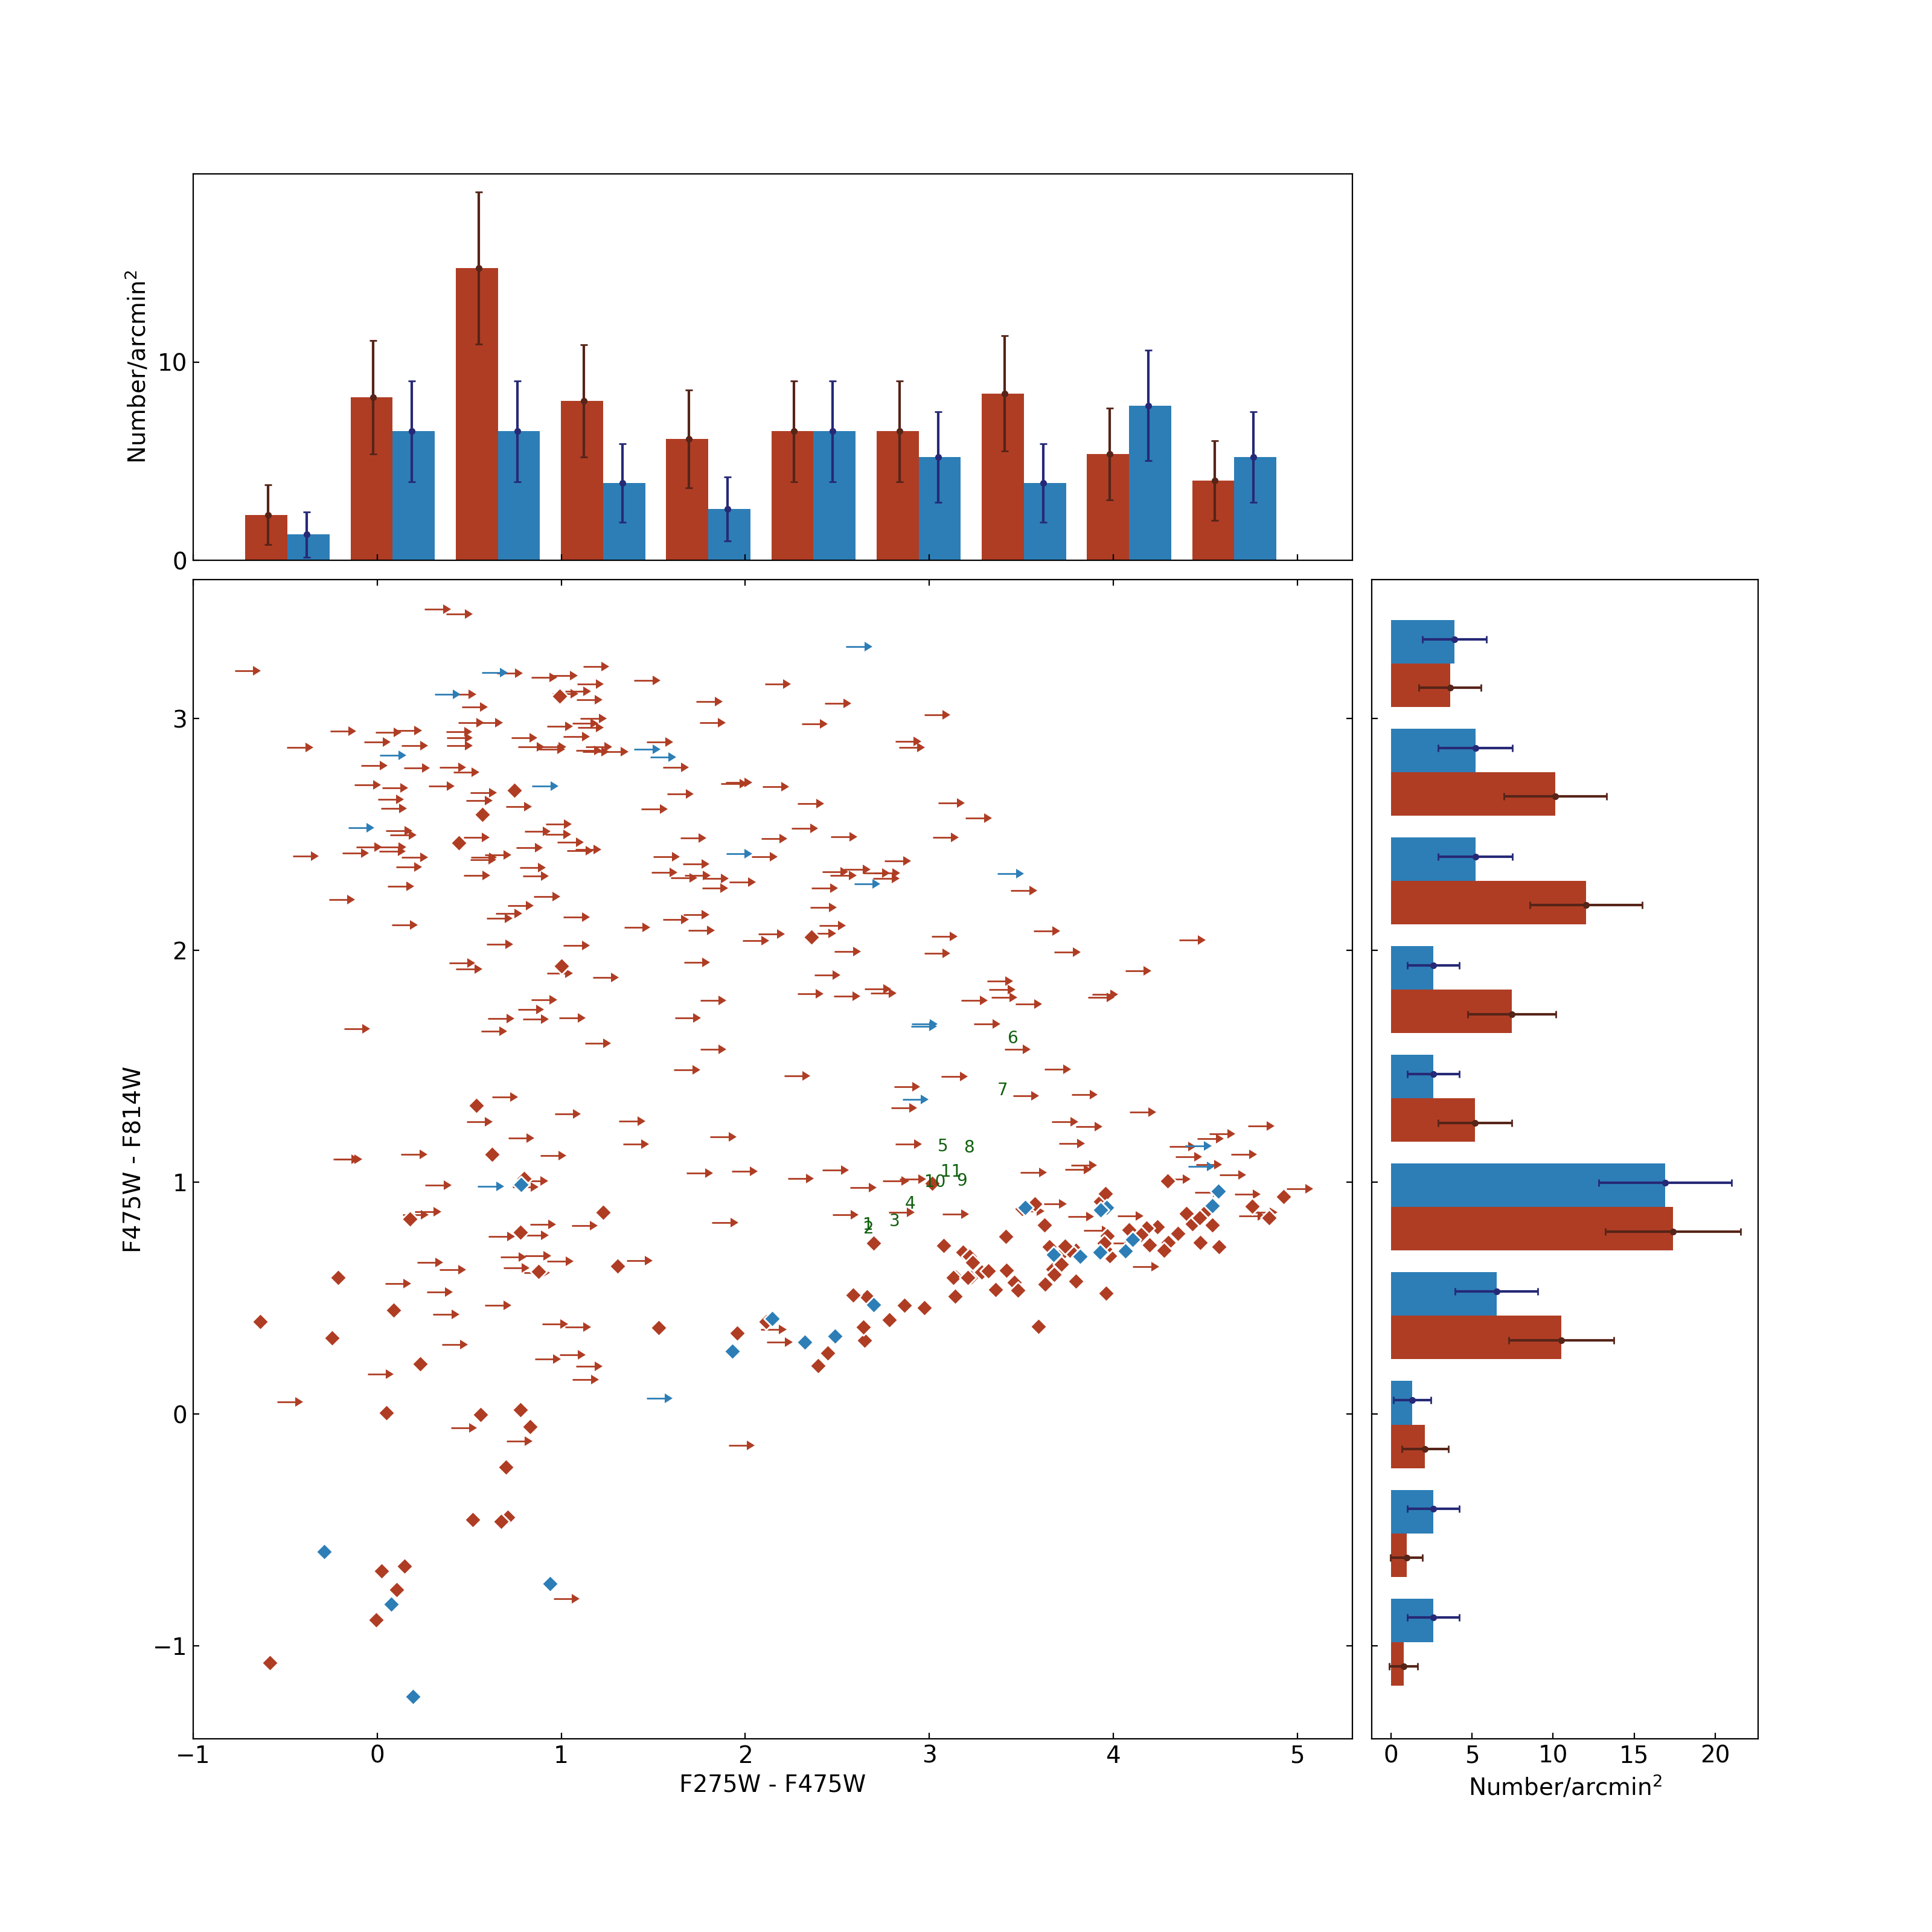

In [21]:
# definitions for the axes
left, width = 0.1, 0.6
bottom, height = 0.1, 0.6
spacing = 0.01

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

plt.figure(figsize=(8, 8))
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
a2=ax_scatter.scatter(mdt42 - mdt44, mdt44 - mdt48 , color='#2D7EB6', s=50,marker='D',edgecolor='w',zorder=9,label='Tail')
a1=ax_scatter.scatter(mdc42 - mdc44, mdc44 - mdc48 ,color='#AF3D24', s=50, marker='D',edgecolor='w',zorder=8,label='Control')
a4=ax_scatter.errorbar(met42 - met44, met44 - met48, xerr=.1,xlolims=True, color='#2D7EB6',fmt='|',linewidth=1.,capsize=3.,mec='w',mew=0.,zorder=7)
a3=ax_scatter.errorbar(mec42 - mec44, mec44 - mec48, xerr=.1,xlolims=True, color='#AF3D24',fmt='|',linewidth=1.,capsize=3.,mec='w',mew=0.,zorder=6)

'''
textstr = '\n'.join((
    'Galaxy' ,
    'Tail' ,
    'Control' ))

props = dict(boxstyle='round', facecolor='white',edgecolor='grey')

# place a text box in upper left in axes coords
ax_scatter.text(4, -0.5, textstr,fontsize=14, color='#AF3D24',
        verticalalignment='top', bbox=props)

'''
ax_scatter.axis([-1,5.3,-1.4,3.6])
ax_scatter.set_xlabel('F275W - F475W')
ax_scatter.set_ylabel('F475W - F814W')
#ax_scatter.legend(shadow=True)

#galaxy_source introduced
yrs4Ann = np.array(range(1,12))
for yr, x1, y1 in zip(yrs4Ann,color_F275W-color_F475W, color_F475W-color_F814W):
    ax_scatter.annotate(text='{:d} '.format(int(yr)), xy=(x1, y1), xytext=(0, 0),
                textcoords='offset points',fontsize=10, color='#105F0D',zorder=10)


n,bins,patches=ax_histx.hist([mc42-mc44,mt42 - mt44],bins=10,histtype='bar', weights=[w_c,w_t],color=['#AF3D24','#2D7EB6'],label=['Control','Tail'])
ax_histx.set_yticks([0,10])
centers = bins[:-1] + np.diff(bins)/2 -0.105
centers_2 = bins[:-1] + np.diff(bins)/2 +0.105
yerr=np.sqrt(np.abs(n))
ax_histx.errorbar(centers, n[0], yerr=yerr[0],fmt='.',capsize=2,color='#562418')
ax_histx.errorbar(centers_2, n[1], yerr=yerr[1],fmt='.',capsize=2,color='#262976')
ax_histx.set_ylabel('Number/arcmin$^2$')
ax_histx.set_xlim(-1,5.3)

n,bins,patches_y=ax_histy.hist([mc44-mc48, mt44 - mt48],bins=10,histtype='bar',weights=[w_c,w_t],color=['#AF3D24','#2D7EB6'],orientation='horizontal')
centers = bins[:-1] + np.diff(bins)/2 -0.105
centers_2 = bins[:-1] + np.diff(bins)/2 +0.105
yerr=np.sqrt(np.abs(n))
ax_histy.errorbar(n[0], centers, xerr=yerr[0],fmt='.',capsize=2,color='#562418')
ax_histy.errorbar(n[1], centers_2,xerr=yerr[1],fmt='.',capsize=2,color='#262976')
ax_histy.set_xlabel('Number/arcmin$^2$')
_ = ax_histy.set_ylim(-1.4,3.6)


#plt.savefig('/Users/sunil/Desktop/upper_limit.eps',dpi=300)


## 7.Starburst 99 and $E_{B-V}$ map

In [22]:

# Galaxy Parameters
REDSHIFT = 0.0191
GAL_DIST = 2.148e26  # in cm

# The PySynPhot Filters
# See https://pysynphot.readthedocs.io/en/latest/appendixb.html
# for instructions on how to call a filter from HST.
filts = {
    275: psp.ObsBandpass('wfc3,uvis2,f275w'),
    475: psp.ObsBandpass('acs,wfc1,f475w'),
    814: psp.ObsBandpass('acs,wfc1,f814w'),
    160: psp.ObsBandpass('wfc3,ir,f160w')
}

# Setup the Desired Reddening Values
# This can be done with an E(B-V) value or an A_v value.
# 
# A few things to note:
#  1. Each of the Extinction routines output a k value and the extinction magnitude
#     You'll notice I am only keeping the ext mag.
#  2. Each of the extinction routines expects the central wavelength to be in *microns*.
#
# For E(B-V), see the next few lines
# For A_v, uncomment the commented lines below then comment the E(B-V) lines
ebv = 0.25,0.10  # Set E(B-V) directly
# A_v = np.arange(0,2)  # Set E(B-V) indirectly
# ebv = A_v/rd.cal00(0.551)[0]
red = {
    275: ext.cal00(0.275, ebv)[1],
    475: ext.cal00(0.475, ebv)[1],
    814: ext.cal00(0.814, ebv)[1],
    160: ext.cal00(1.600, ebv)[1]
}

In [23]:
# Read in the File
sb99 = ssp.Starburst99Spectrum(SSP_FILE_NAME, redshift=REDSHIFT, distToSrc=GAL_DIST)

In [24]:
# Get the Source Magnitudes
mag, magExt, magExt_1 = {}, {}, {}
for key in filts:
    mag[key] = sb99.makeobservation(filts[key], outUnit='ABMag')  # Make Observation (no ext)
    magExt[key] = mag[key] + red[key][0]  # Add the Extinction to the Observations
    magExt_1[key] = mag[key] + red[key][1]

## Histogram with SB99 tracks in the all band detection

<IPython.core.display.Javascript object>


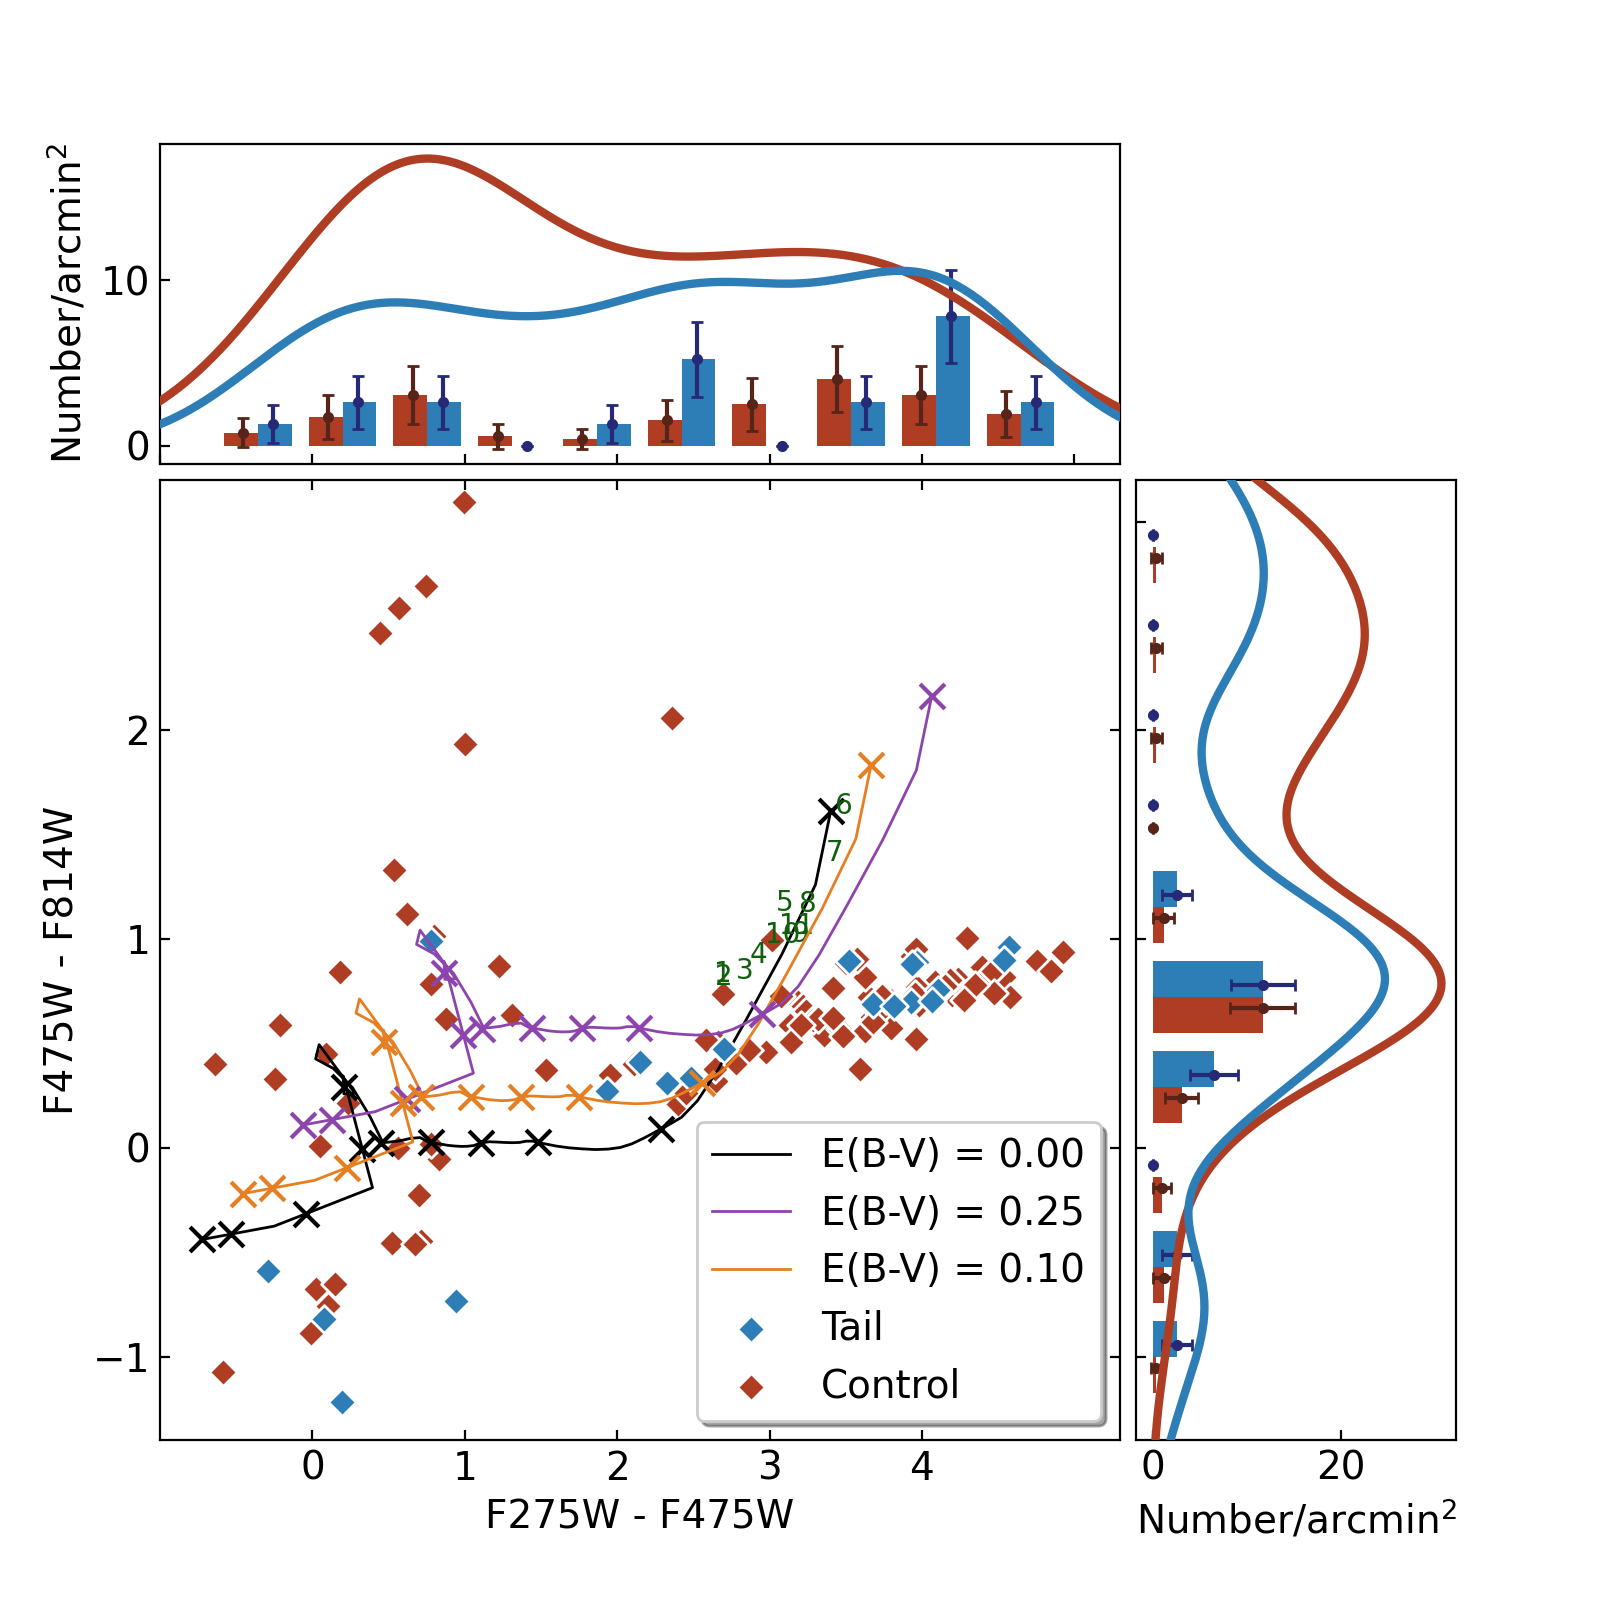

In [25]:
# definitions for the axes
left, width = 0.1, 0.6
bottom, height = 0.1, 0.6
spacing = 0.01


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in',labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)



ax_scatter.scatter((mdt42-mdt44),(mdt44-mdt48),color='#2D7EB6',s=50,marker='D',edgecolor='w',label='Tail',zorder=2)
ax_scatter.scatter((mdc42-mdc44),(mdc44-mdc48),color='#AF3D24',s=50,marker='D',edgecolor='w', label='Control',zorder=1)
ax_scatter.set_xlabel('F275W - F475W')
ax_scatter.set_ylabel('F475W - F814W')
#ax_scatter.legend(loc='best')
ax_scatter.set_yticks([-1,0,1,2])
ax_scatter.set_xticks([0,1,2,3,4])
ax_scatter.axis([-1,5.3,-1.4,3.2])
#galaxy_source introduced
gal_srcs = np.array(range(1,12))
for yr, x1, y1 in zip(gal_srcs,color_F275W-color_F475W, color_F475W-color_F814W):
    ax_scatter.annotate(text='{:d} '.format(int(yr)), xy=(x1, y1), xytext=(0, 0),
                textcoords='offset points', fontsize=10,color='#105F0D', zorder=3)
    
# Years for Annotations
yrs4Ann = 1e6*np.array([1, 3, 5, 7, 10, 30, 50, 100, 200, 500, 1000])

# Get XY
# Get the XY Values
x, xExt, xExt_1 = mag[275] - mag[475], magExt[275] - magExt[475], magExt_1[275] - magExt_1[475]
y, yExt, yExt_1 = mag[475] - mag[814], magExt[475] - magExt[814], magExt_1[475] - magExt_1[814]

# Plot the Tracks
ax_scatter.plot(x, y, linewidth=1, color='k',label='E(B-V) = 0.00', zorder=1)
ax_scatter.plot(xExt, yExt, linewidth=1, color='#8E44AD',label='E(B-V) = {:.2f}'.format(ebv[0]), zorder=4)
ax_scatter.plot(xExt_1, yExt_1, linewidth=1, color='#E67E22',label='E(B-V) = {:.2f}'.format(ebv[1]), zorder=4)

# Plot the Non-Extinction Markers
xAnn, yAnn = np.interp(yrs4Ann, sb99.years, x), np.interp(yrs4Ann, sb99.years, y)
ax_scatter.scatter(xAnn, yAnn, s=80, c='k', marker='x', zorder=3)

# Plot the Extinction Markers
xAnn, yAnn = np.interp(yrs4Ann, sb99.years, xExt), np.interp(yrs4Ann, sb99.years, yExt)
ax_scatter.scatter(xAnn, yAnn, s=80, c='#8E44AD', marker='x', zorder=5)
xAnn, yAnn = np.interp(yrs4Ann, sb99.years, xExt_1), np.interp(yrs4Ann, sb99.years, yExt_1)
ax_scatter.scatter(xAnn, yAnn, s=80, c='#E67E22', marker='x', zorder=5)
props = dict(boxstyle='round',facecolor='white',edgecolor='grey')
#ax_scatter.text(-0.5,1.9,'SB99; Genv00; Z=0.014', bbox=props)
ll=ax_scatter.legend(shadow=True, loc='lower right')
ll.set_zorder(2)


n,bins,patches=ax_histx.hist([mdc42-mdc44,mdt42 - mdt44],bins=10,weights=[wd_c,wd_t],color=['#AF3D24','#2D7EB6'])
p1,=ax_histx.plot(mns1, est1/5.229, color='#AF3D24',lw=3,zorder=6)
p2,=ax_histx.plot(mns2, est2/0.7684, color='#2D7EB6', lw=3,zorder=7)

ax_histx.set_xlim(-1,5.3)
ax_histx.set_yticks([0,10,20])
centers = bins[:-1] + np.diff(bins)/2 -0.095
centers_2 = bins[:-1] + np.diff(bins)/2 +0.10
yerr=np.sqrt(np.abs(n))
ax_histx.errorbar(centers, n[0], yerr=yerr[0],fmt='.',capsize=2,color='#562418')
ax_histx.errorbar(centers_2, n[1], yerr=yerr[1],fmt='.',capsize=2,color='#262976')
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
#ax_histx.legend([(p1,p2)], ['F275W Detections + Upper Limits'], numpoints=1,
#               handler_map={tuple: HandlerTuple(ndivide=None)},fontsize=10,shadow=True)


n,bins,patches=ax_histy.hist([mdc44 - mdc48,mdt44-mdt48],bins=10, weights=[wd_c,wd_t],color=['#AF3D24','#2D7EB6'],label=['Control','Tail'],orientation='horizontal')
ax_histy.plot(est3/5.229,mns3, lw=3,color='#AF3D24',zorder=8)
ax_histy.plot(est4/0.7684,mns4, lw=3,color='#2D7EB6',zorder=9)
ax_histy.set_ylim(-1.4,3.2)
centers = bins[:-1] + np.diff(bins)/2-0.055 
centers_2 = bins[:-1] + np.diff(bins)/2 +0.055
yerr=np.sqrt(np.abs(n))
ax_histy.errorbar(n[0], centers, xerr=yerr[0],fmt='.',capsize=2,color='#562418',label='Control_error')
ax_histy.errorbar(n[1], centers_2,xerr=yerr[1],fmt='.',capsize=2,color='#262976',label='Tail_error')

_ = ax_histx.set_ylabel(r'Number/arcmin$^2$')
_ = ax_histy.set_xlabel(r'Number/arcmin$^2$')
#plt.savefig('/Users/sunil/Desktop/all_detection.eps',dpi=300)


### SB99 color-color map

In [26]:
# same values for all plots except Cloudy
# Years for Annotations
yrs4Ann = 1e6*np.array([1, 3, 5, 10, 30, 50,100, 200, 500, 1000])

<IPython.core.display.Javascript object>


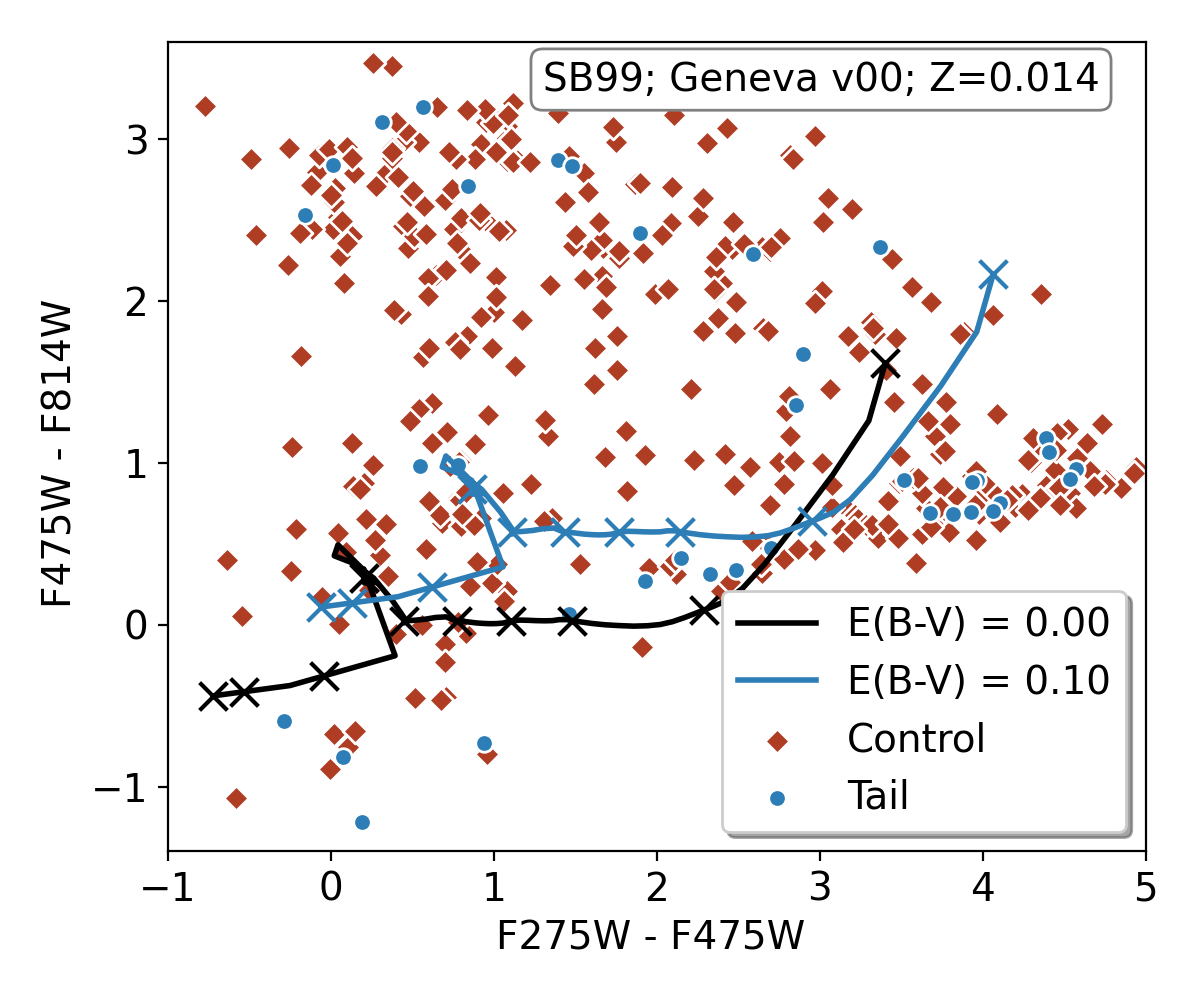

In [33]:
fig, ax = plt.subplots(figsize=(6,5))

# Plot the Tracks
_ = ax.plot(x, y, linewidth=2, color='k',label='E(B-V) = 0.00', zorder=1)
_ = ax.plot(xExt, yExt, linewidth=2, color='#2D7EB6',label='E(B-V) = {:.2f}'.format(ebv[1]), zorder=2)

# Annotate Line with Years
# Plot the Non-Extinction Markers
xAnn, yAnn = np.interp(yrs4Ann, sb99.years, x), np.interp(yrs4Ann, sb99.years, y)
_ = ax.scatter(xAnn, yAnn, s=100, c='k', marker='x', zorder=3)

# Plot the Extinction Markers
xAnn, yAnn = np.interp(yrs4Ann, sb99.years, xExt), np.interp(yrs4Ann, sb99.years, yExt)
_ = ax.scatter(xAnn, yAnn, s=100, c='#2D7EB6', marker='x', zorder=4)

# Labels
_ = ax.scatter(mc42 - mc44, mc44 - mc48, label='Control', color='#AF3D24',s=40,marker='D',edgecolor='w')
_ = ax.scatter(mt42 - mt44, mt44 - mt48, label='Tail' , color='#2D7EB6', s=40,marker='o',edgecolor='w')
_ = ax.set_xlabel('F275W - F475W ')
_ = ax.set_ylabel('F475W - F814W ')
_ = ax.axis([-1,5.,-1.4,3.6])
props = dict(boxstyle='round',facecolor='white',edgecolor='grey')
_ = ax.text(1.3,3.3,'SB99; Geneva v00; Z=0.014', bbox=props)
_ = ax.legend(loc='lower right',shadow=True)
plt.tight_layout()

## SB99 color-mag map for 10$^5$ M$\odot$

<IPython.core.display.Javascript object>


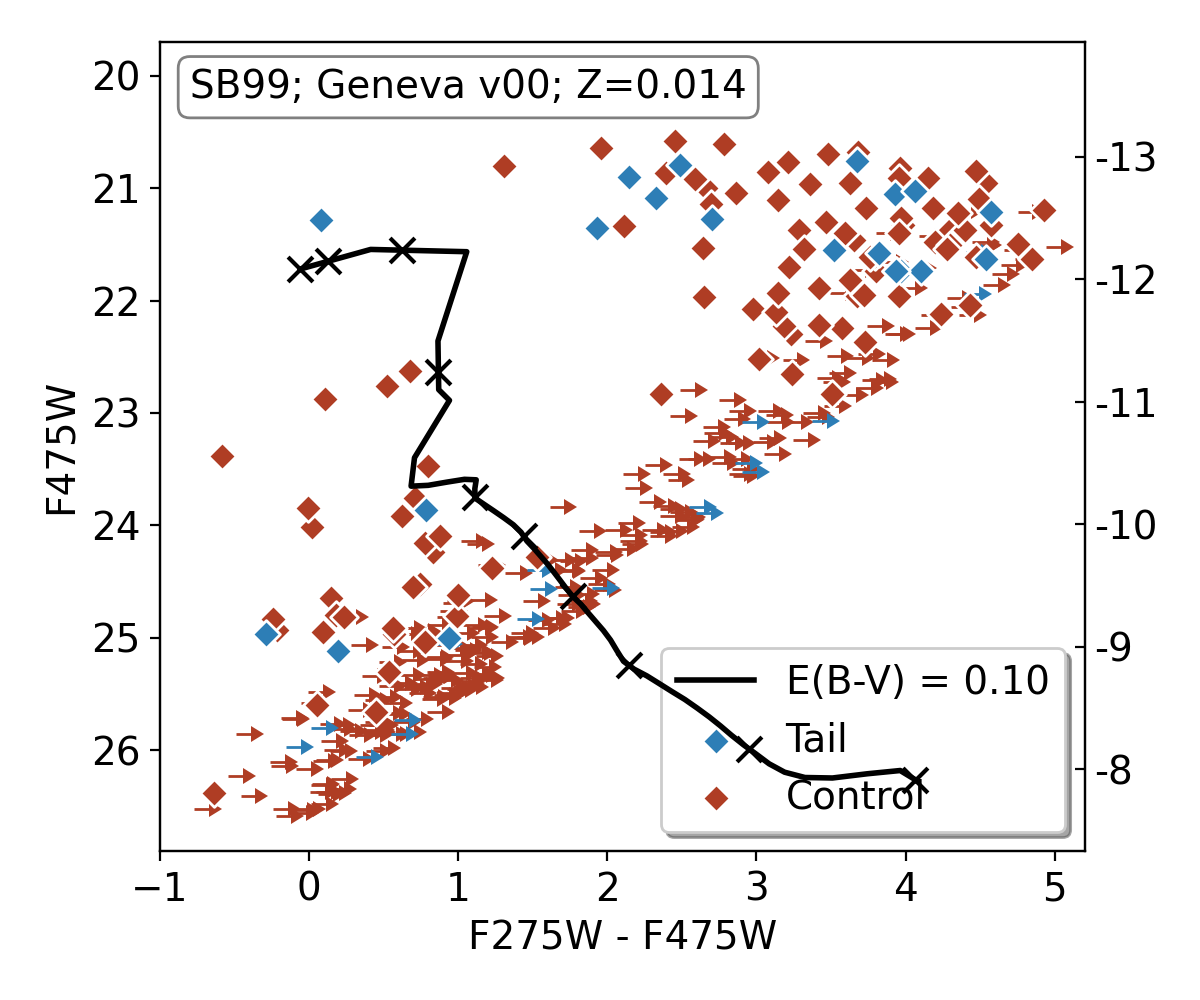

In [35]:
fig, ax = plt.subplots(figsize=(6,5))

# Get XY
yExt =magExt[475] 


# Plot the Tracks

_ = ax.plot(xExt, yExt +2.5, linewidth=2, color='k',label='E(B-V) = {:.2f}'.format(ebv[1]), zorder=5)

# Plot the Extinction Markers
xAnn, yAnn = np.interp(yrs4Ann, sb99.years, xExt), np.interp(yrs4Ann, sb99.years, yExt)
_ = ax.scatter(xAnn, yAnn+2.5, s=80, c='k', marker='x', zorder=5)

# Labels
_ = ax.scatter(mdt42-mdt44,mdt44, color='#2D7EB6',s=50,marker='D',edgecolor='w',label='Tail',zorder=4)
_ = ax.scatter(mdc42-mdc44,mdc44, color='#AF3D24',s=50,marker='D',edgecolor='w', label='Control',zorder=3)
_ = ax.errorbar(met42 - met44, met44, xerr=.1,xlolims=True, color='#2D7EB6',fmt='|',linewidth=1.,capsize=3.,mec='w',mew=0.,zorder=2)
_ = ax.errorbar(mec42 - mec44, mec44, xerr=.1,xlolims=True, color='#AF3D24',fmt='|',linewidth=1.,capsize=3.,mec='w',mew=0.,zorder=1)
_ = ax.set_xlabel('F275W - F475W')
_ = ax.set_ylabel('F475W')

#-----------------secondary y ticks
axT = ax.twinx()
yT = ax.get_yticks()
yT +=0.213
axT.set_yticks(yT)
yTabs =yT - 5*np.log10(69.6e5)
yTabs = list(map('{:.0f}'.format, yTabs))
axT.set_yticklabels(yTabs)
axT.set_ylim(ax.get_ylim())
axT.invert_yaxis()
_ = ax.axis([-1.,5.2,26.9,19.7])

props = dict(boxstyle='round',facecolor='white',edgecolor='grey')
_ = ax.text(-.8,20.2,'SB99; Geneva v00; Z=0.014', bbox=props, zorder=2)
dd= ax.legend(loc='lower right', shadow=True, framealpha=1.)
dd.set_zorder(2)
plt.tick_params(axis='both',direction='in')
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)

## CM map using SB99+Cloudy for 10$^4$ M$\odot$ 

In [27]:

# Galaxy Parameters
REDSHIFT = 0.0191
GAL_DIST = 2.148e26  # in cm

#I added 133.20781 because mags were offset by this value. Won't have problem with color-color without this.
filts = {
    275: cloudy['F275W']+ 133.20781,
    475: cloudy['F475W']+ 133.20781,
    814: cloudy['F814W']+ 133.20781
}

ebv = 0.25,0.10  # Set E(B-V) directly
red = {
    275: ext.cal00(0.275, ebv)[1],
    475: ext.cal00(0.475, ebv)[1],
    814: ext.cal00(0.814, ebv)[1]
}

### just use eb-v=0.161

In [54]:

# Galaxy Parameters
REDSHIFT = 0.0191
GAL_DIST = 2.148e26  # in cm

#I added 133.20781 because mags were offset by this value. Won't have problem with color-color without this.
filts = {
    275: cloudy['F275W']+ 133.20781,
    475: cloudy['F475W']+ 133.20781,
    814: cloudy['F814W']+ 133.20781
}

ebv = 0.161,0.10  # Set E(B-V) directly
red = {
    275: ext.cal00(0.275, ebv)[1],
    475: ext.cal00(0.475, ebv)[1],
    814: ext.cal00(0.814, ebv)[1]
}

In [55]:
# Get the Source Magnitudes
mag, magExt, magExt_1 = {}, {}, {}
for key in filts:
    mag[key] = filts[key] # Make Observation (no ext)
    magExt[key] = mag[key] + red[key][0]  # Add the Extinction to the Observations
    magExt_1[key] = mag[key] + red[key][1]

## Histogram with SB99 tracks in the all band detection

<IPython.core.display.Javascript object>


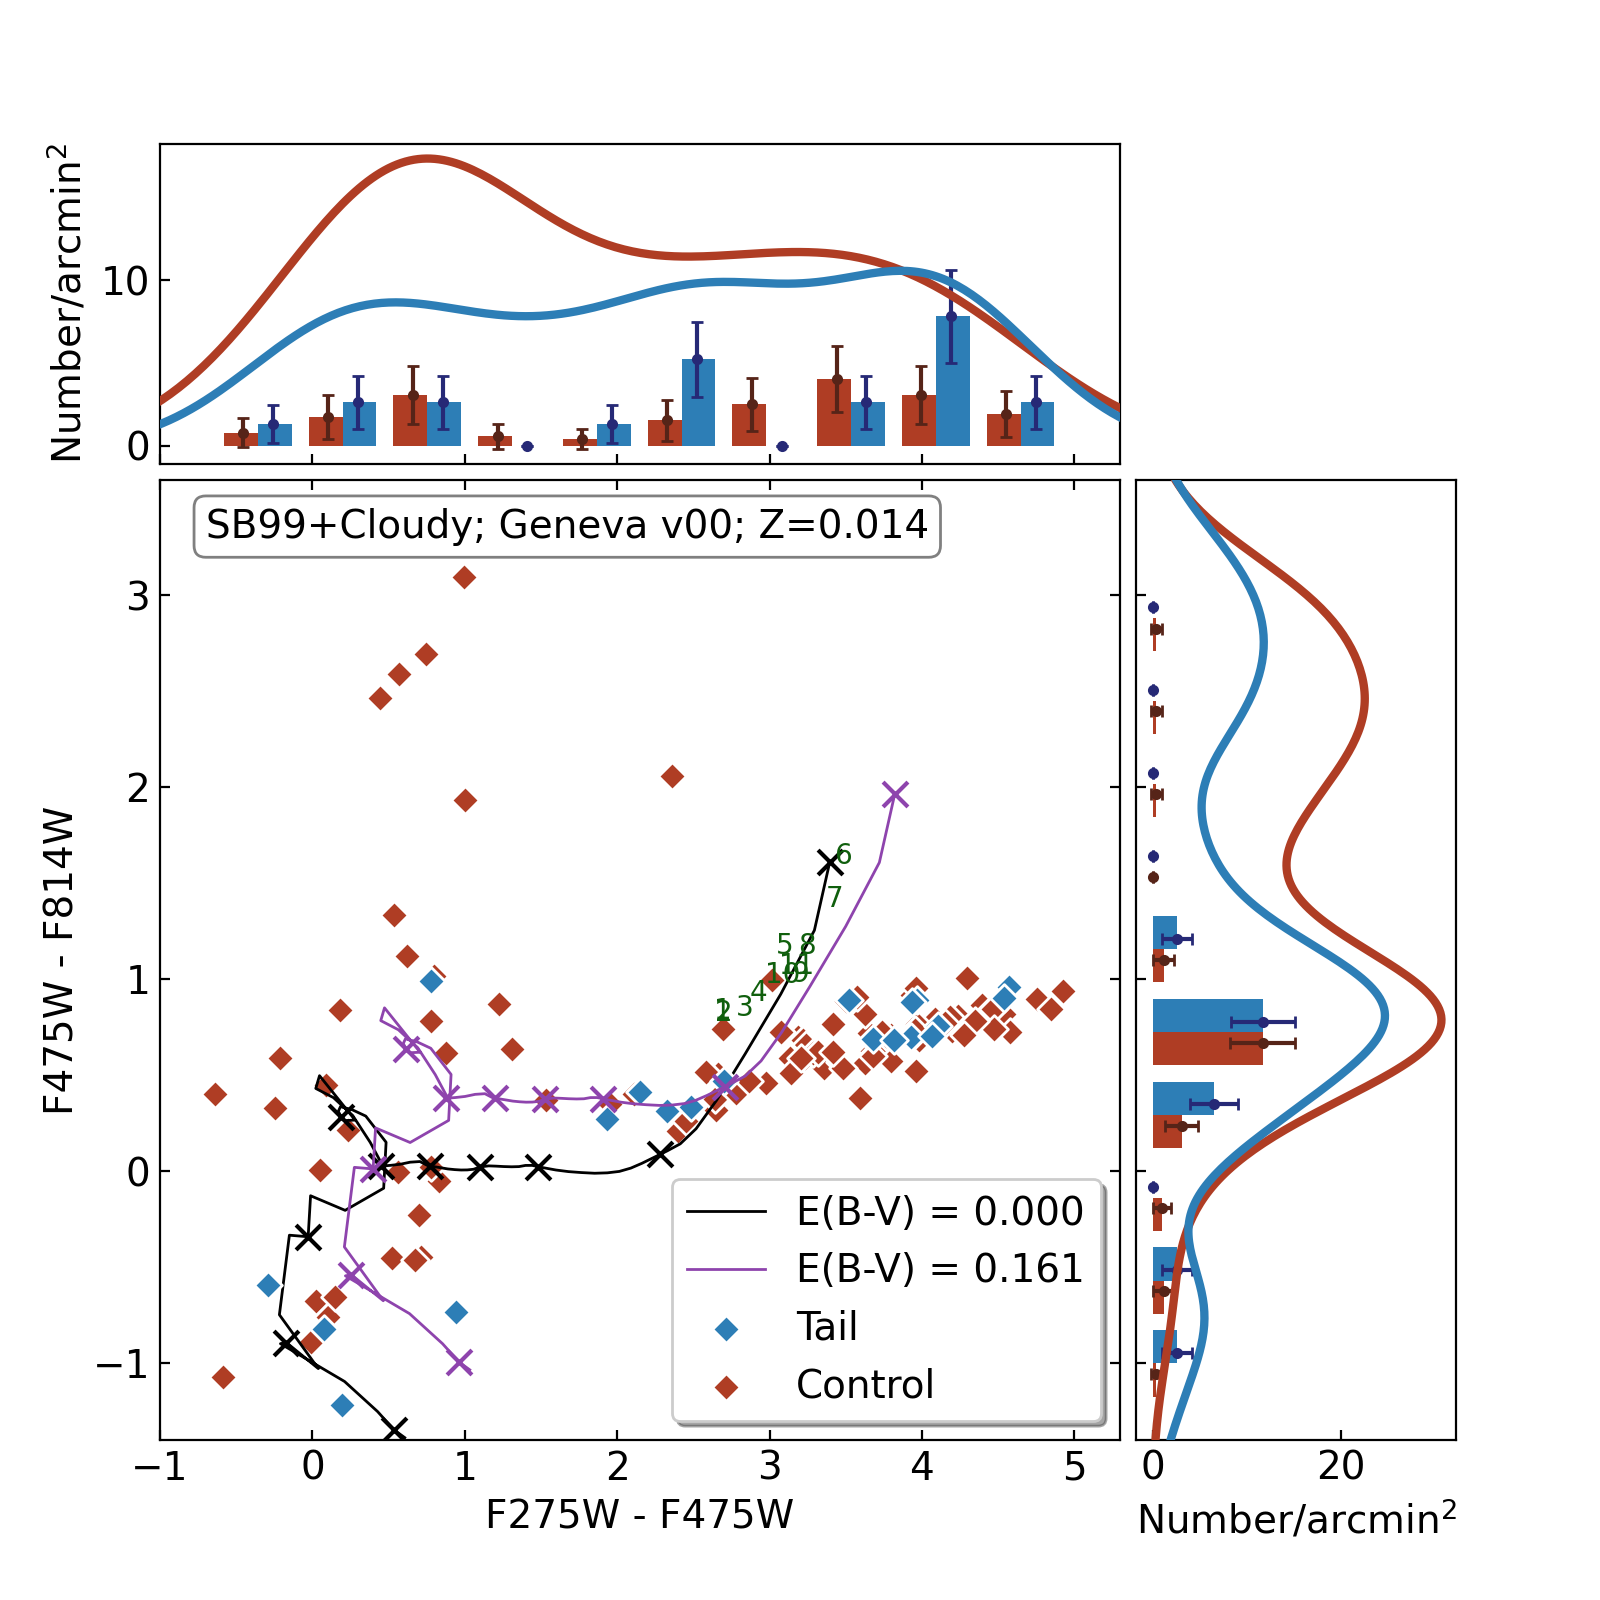

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [36]:
# definitions for the axes
left, width = 0.1, 0.6
bottom, height = 0.1, 0.6
spacing = 0.01


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in',labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)



ax_scatter.scatter((mdt42-mdt44),(mdt44-mdt48),color='#2D7EB6',s=50,marker='D',edgecolor='w',label='Tail',zorder=2)
ax_scatter.scatter((mdc42-mdc44),(mdc44-mdc48),color='#AF3D24',s=50,marker='D',edgecolor='w', label='Control',zorder=1)
ax_scatter.set_xlabel('F275W - F475W')
ax_scatter.set_ylabel('F475W - F814W')
#ax_scatter.set_yticks([-1,0,1,2])
#ax_scatter.set_xticks([0,1,2,3,4])
ax_scatter.axis([-1,5.3,-1.4,3.6])

#galaxy_source introduced
gal_srcs = np.array(range(1,12))
for yr, x1, y1 in zip(gal_srcs,color_F275W-color_F475W, color_F475W-color_F814W):
    ax_scatter.annotate(text='{:d} '.format(int(yr)), xy=(x1, y1), xytext=(0, 0),
                textcoords='offset points', fontsize=10,color='#105F0D', zorder=3)
    
# Years for Annotations
yrs4Ann = 1e6*np.array([1, 3, 5, 10, 30, 50, 100, 200, 500, 1000])

# Get XY
# Get the XY Values
x, xExt, xExt_1 = mag[275] - mag[475], magExt[275] - magExt[475], magExt_1[275] - magExt_1[475]
y, yExt, yExt_1 = mag[475] - mag[814], magExt[475] - magExt[814], magExt_1[475] - magExt_1[814]

# Plot the Tracks
ax_scatter.plot(x, y, linewidth=1, color='k',label='E(B-V) = 0.000', zorder=1)
ax_scatter.plot(xExt, yExt, linewidth=1, color='#8E44AD',label='E(B-V) = {:.3f}'.format(ebv[0]), zorder=4)
#ax_scatter.plot(xExt_1, yExt_1, linewidth=1, color='#E67E22',label='E(B-V) = {:.2f}'.format(ebv[1]), zorder=4)

# Plot the Non-Extinction Markers
xAnn, yAnn = np.interp(yrs4Ann, cloudy['Years'], x), np.interp(yrs4Ann, cloudy['Years'], y)
_ = ax_scatter.scatter(xAnn, yAnn, s=80, c='k', marker='x', zorder=3)

# Plot the Extinction Markers
xAnn, yAnn = np.interp(yrs4Ann, cloudy['Years'], xExt), np.interp(yrs4Ann, cloudy['Years'], yExt)
_ = ax_scatter.scatter(xAnn, yAnn, s=80, c='#8E44AD', marker='x', zorder=5)
#xAnn, yAnn = np.interp(yrs4Ann, cloudy['Years'], xExt_1), np.interp(yrs4Ann, cloudy['Years'], yExt_1)
#_ =  ax_scatter.scatter(xAnn, yAnn, s=80, c='#E67E22', marker='x', zorder=5)
props = dict(boxstyle='round',facecolor='white',edgecolor='grey')
_ = ax_scatter.text(-0.7,3.3,'SB99+Cloudy; Geneva v00; Z=0.014', bbox=props, zorder=0)
ll=ax_scatter.legend(shadow=True, loc='lower right')
ll.set_zorder(2)


n,bins,patches=ax_histx.hist([mdc42-mdc44,mdt42 - mdt44],bins=10,weights=[wd_c,wd_t],color=['#AF3D24','#2D7EB6'])
p1,=ax_histx.plot(mns1, est1/5.229, color='#AF3D24',lw=3,zorder=6)
p2,=ax_histx.plot(mns2, est2/0.7684, color='#2D7EB6', lw=3,zorder=7)
ax_histx.set_xlim(-1,5.3)
ax_histx.set_yticks([0,10,20])
centers = bins[:-1] + np.diff(bins)/2 -0.095
centers_2 = bins[:-1] + np.diff(bins)/2 +0.10
yerr=np.sqrt(np.abs(n))
ax_histx.errorbar(centers, n[0], yerr=yerr[0],fmt='.',capsize=2,color='#562418')
ax_histx.errorbar(centers_2, n[1], yerr=yerr[1],fmt='.',capsize=2,color='#262976')
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
#ax_histx.legend([(p1,p2)], ['F275W Detections + Upper Limits'], numpoints=1,
#               handler_map={tuple: HandlerTuple(ndivide=None)},fontsize=10,shadow=True)


n,bins,patches=ax_histy.hist([mdc44 - mdc48,mdt44-mdt48],bins=10, weights=[wd_c,wd_t],color=['#AF3D24','#2D7EB6'],label=['Control','Tail'],orientation='horizontal')
ax_histy.plot(est3/5.229,mns3, lw=3,color='#AF3D24',zorder=8)
ax_histy.plot(est4/0.7684,mns4, lw=3,color='#2D7EB6',zorder=9)
ax_histy.set_ylim(-1.4,3.6)
centers = bins[:-1] + np.diff(bins)/2-0.055 
centers_2 = bins[:-1] + np.diff(bins)/2 +0.055
yerr=np.sqrt(np.abs(n))
ax_histy.errorbar(n[0], centers, xerr=yerr[0],fmt='.',capsize=2,color='#562418',label='Control_error')
ax_histy.errorbar(n[1], centers_2,xerr=yerr[1],fmt='.',capsize=2,color='#262976',label='Tail_error')

_ = ax_histx.set_ylabel(r'Number/arcmin$^2$')
_ = ax_histy.set_xlabel(r'Number/arcmin$^2$')
#plt.savefig('/Users/sunil/Desktop/all_detection.eps',dpi=300)


<IPython.core.display.Javascript object>


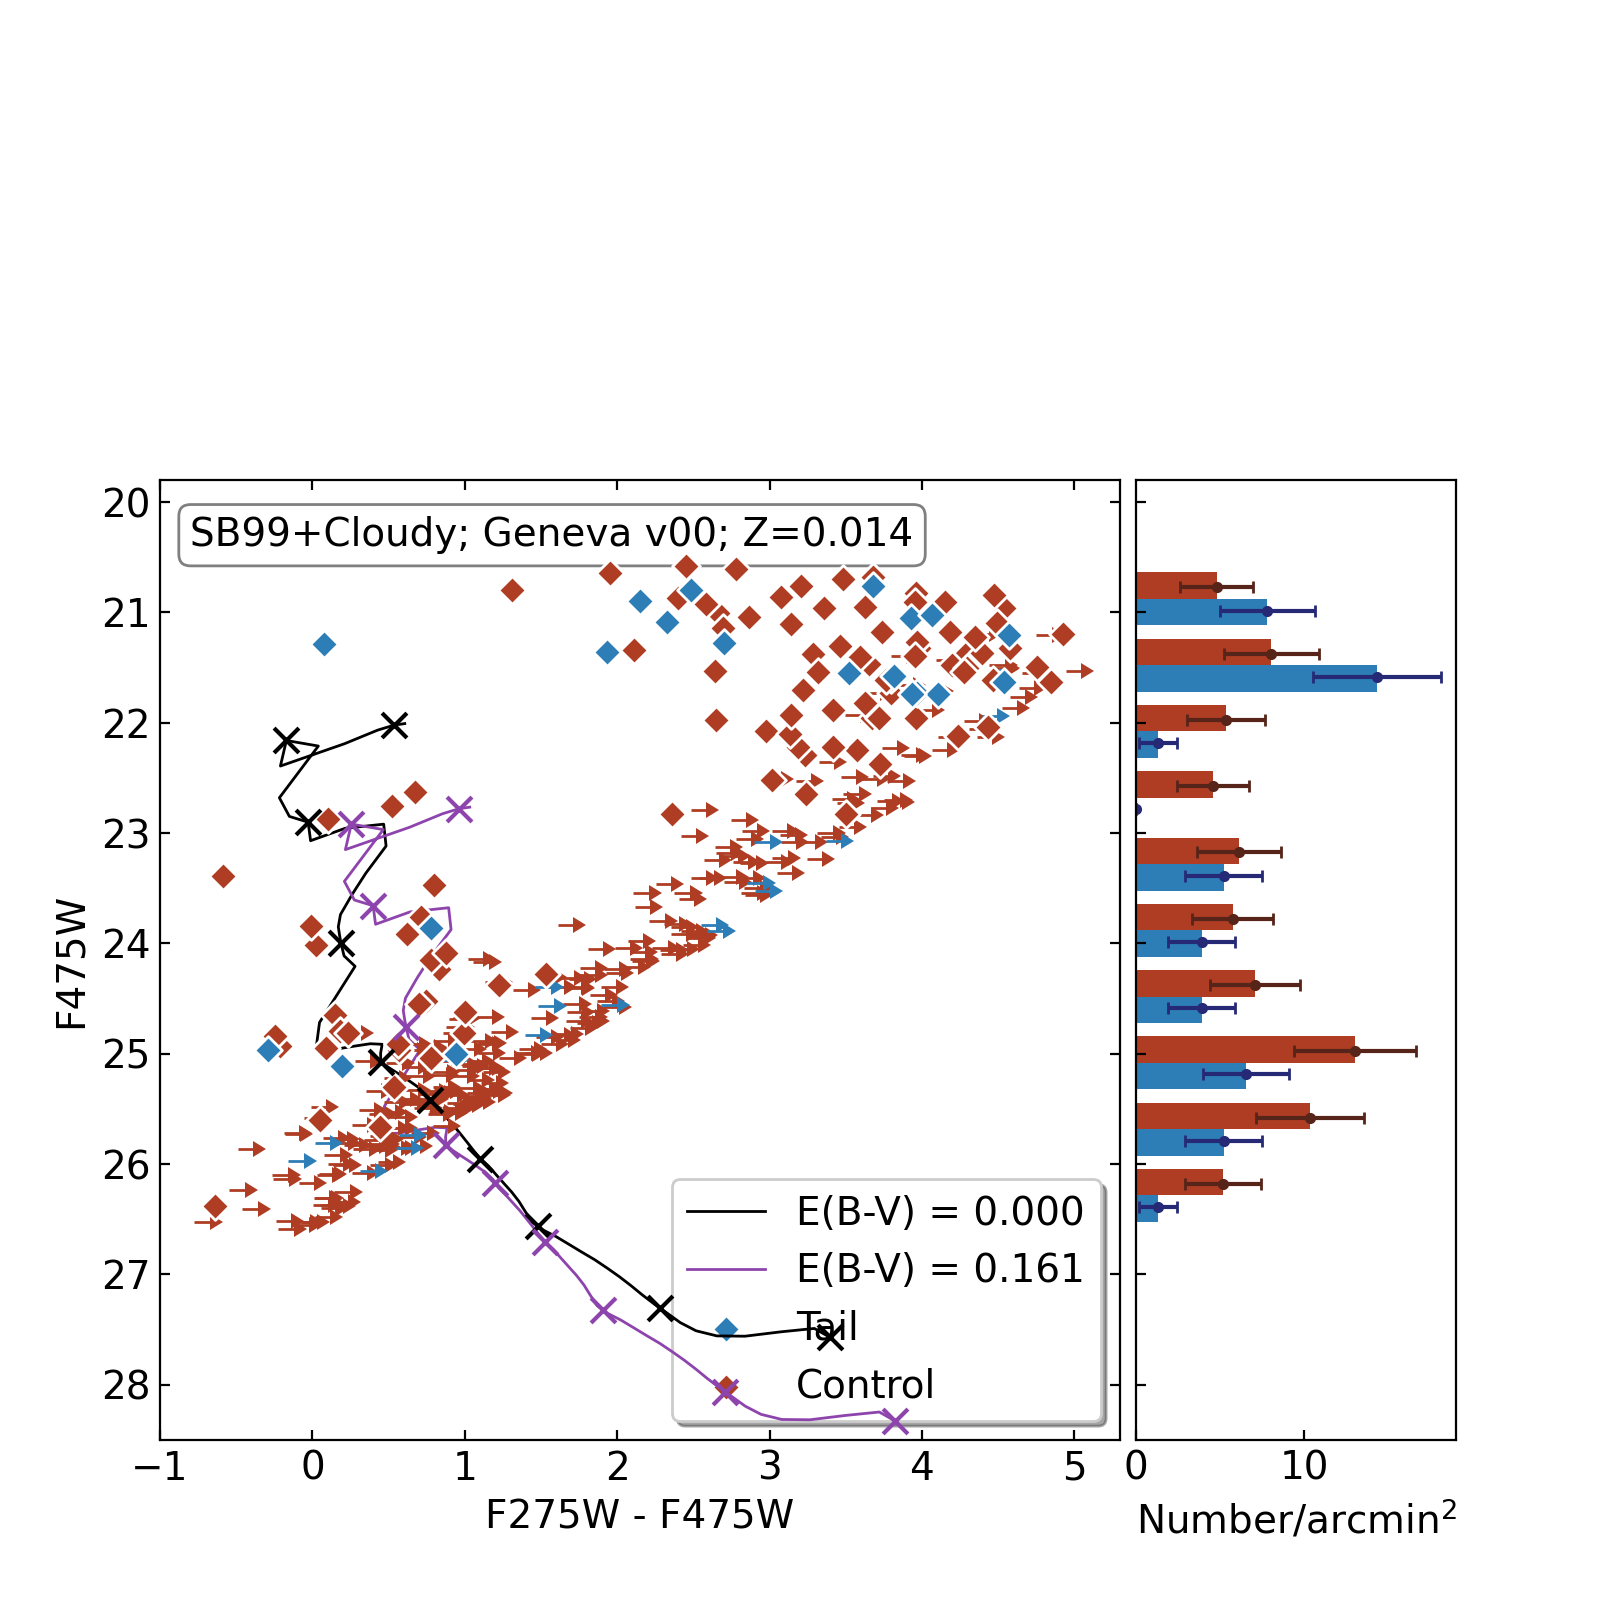

/Users/sunil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [44]:
# definitions for the axes

left, width = 0.1, 0.6
bottom, height = 0.1, 0.6
spacing = 0.01

rect_scatter = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]

plt.figure(figsize=(8, 8))
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
a2=ax_scatter.scatter(mdt42 - mdt44, mdt44 , color='#2D7EB6', s=50,marker='D',edgecolor='w',zorder=9,label='Tail')
a1=ax_scatter.scatter(mdc42 - mdc44, mdc44 ,color='#AF3D24', s=50, marker='D',edgecolor='w',zorder=8,label='Control')
a4=ax_scatter.errorbar(met42 - met44, met44, xerr=.1,xlolims=True, color='#2D7EB6',fmt='|',linewidth=1.,capsize=3.,mec='w',mew=0.,zorder=7)
a3=ax_scatter.errorbar(mec42 - mec44, mec44, xerr=.1,xlolims=True, color='#AF3D24',fmt='|',linewidth=1.,capsize=3.,mec='w',mew=0.,zorder=6)
ax_scatter.axis([-1,5.3,28.5,19.8])
ax_scatter.set_xlabel('F275W - F475W')
ax_scatter.set_ylabel('F475W')

#------------------SB99
# Get XY
# Get the XY Values
#x, xExt = mag[275] - mag[475], magExt[275] - magExt[475]
y, yExt = mag[475], magExt[475]

# Plot the Tracks
_ = ax_scatter.plot(x, y+5, linewidth=1,color='k', label='E(B-V) = 0.000',zorder=1)
_ = ax_scatter.plot(xExt, yExt+5, linewidth=1,color='#8E44AD',label='E(B-V) = {:.3f}'.format(ebv[0]),zorder=2)

# Plot the Non-Extinction Markers
xAnn, yAnn = np.interp(yrs4Ann, cloudy['Years'], x), np.interp(yrs4Ann, cloudy['Years'], y)
_ = ax_scatter.scatter(xAnn, yAnn+5, s=80, c='k', marker='x', zorder=11)


# Plot the Extinction Markers
xAnn, yAnn = np.interp(yrs4Ann, cloudy['Years'], xExt), np.interp(yrs4Ann, cloudy['Years'], yExt)
_ = ax_scatter.scatter(xAnn, yAnn+5, s=80, c='#8E44AD', marker='x', zorder=11)


n,bins,patches_y=ax_histy.hist([mc44, mt44],bins=10,histtype='bar',weights=[w_c,w_t],color=['#AF3D24','#2D7EB6'],orientation='horizontal')
centers = bins[:-1] + np.diff(bins)/2 -0.105
centers_2 = bins[:-1] + np.diff(bins)/2 +0.105
yerr=np.sqrt(np.abs(n))
ax_histy.errorbar(n[0], centers, xerr=yerr[0],fmt='.',capsize=2,color='#562418')
ax_histy.errorbar(n[1], centers_2,xerr=yerr[1],fmt='.',capsize=2,color='#262976')
ax_histy.set_xlabel('Number/arcmin$^2$')
ax_histy.set_ylim(28.5,19.8)


props = dict(boxstyle='round',facecolor='white',edgecolor='grey')
_ = ax_scatter.text(-.8,20.4,'SB99+Cloudy; Geneva v00; Z=0.014', bbox=props, zorder=2)

dd= ax_scatter.legend(loc='lower right', shadow=True, framealpha=1.)
dd.set_zorder(0)
plt.tight_layout()
#plt.savefig('/Users/sunil/Desktop/color_mag.eps',dpi=300)

## delete later

## test extreme srcs

In [62]:
color_F475W_control=(mt42 - mt44) < 0.3

In [63]:
f44[notedge_F475W][mask_F475W][inSpurr_f475W][err_f475W][inTail_F475W][color_F475W_control]['NUMBER', 'X_IMAGE','Y_IMAGE', 'FLUX_APER','MAG_APER']                                                                                     

NUMBER,X_IMAGE,Y_IMAGE,FLUX_APER,MAG_APER
,pix,pix,ct,mag
int64,float64,float64,float64,float64
818,2235.791,2462.9106,0.6930986,25.804012445974493
1320,3438.1636,3181.6782,44.48848,21.285381080420258
1797,2994.3091,3775.9956,0.5934927,25.972461546319458
2561,3960.7124,4785.8667,1.494979,24.96941226960001
2601,4196.145,4835.1216,1.308252,25.114271481642156


In [64]:
mt42[color_F475W_control] - mt44[color_F475W_control]

0.014568036526817707
0.07627870741820786
-0.157630905024007
-0.28835111498598565
0.1938131087113959
